In [ ]:
# Written by Mohammadreza Salehi. All rights reserved.

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7]
regularization_strengths = [1e3, 2e3, 5e3, 1e4, 2e4, 5e4]

results = {}
best_val = -1
best_svm, best_reg, best_lr = None, None, None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        print("Learning_rate: {}, reg: {}".format(learning_rate, reg))
        svm = LinearSVM()
        _ = svm.train(X_train_feats, y_train, learning_rate=learning_rate, 
                         reg=reg, num_iters=2000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
            best_lr = learning_rate
            best_reg = reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print("best parameters: Learning_rate = {}, reg = {}".format(best_lr, best_reg))

Learning_rate: 1e-07, reg: 1000.0
iteration 0 / 2000: loss 10.587822
iteration 100 / 2000: loss 10.534951
iteration 200 / 2000: loss 10.463065
iteration 300 / 2000: loss 10.418823
iteration 400 / 2000: loss 10.351480
iteration 500 / 2000: loss 10.314338
iteration 600 / 2000: loss 10.261593
iteration 700 / 2000: loss 10.207141
iteration 800 / 2000: loss 10.160111
iteration 900 / 2000: loss 10.111886
iteration 1000 / 2000: loss 10.070221
iteration 1100 / 2000: loss 10.029958
iteration 1200 / 2000: loss 9.988128
iteration 1300 / 2000: loss 9.958942
iteration 1400 / 2000: loss 9.907742
iteration 1500 / 2000: loss 9.878373
iteration 1600 / 2000: loss 9.844299
iteration 1700 / 2000: loss 9.801306
iteration 1800 / 2000: loss 9.770374
iteration 1900 / 2000: loss 9.746753
Learning_rate: 1e-07, reg: 2000.0
iteration 0 / 2000: loss 12.072875
iteration 100 / 2000: loss 11.817490
iteration 200 / 2000: loss 11.609126
iteration 300 / 2000: loss 11.413174
iteration 400 / 2000: loss 11.221848
iteration

iteration 1300 / 2000: loss 8.999067
iteration 1400 / 2000: loss 8.999182
iteration 1500 / 2000: loss 8.998994
iteration 1600 / 2000: loss 8.999117
iteration 1700 / 2000: loss 8.999042
iteration 1800 / 2000: loss 8.999229
iteration 1900 / 2000: loss 8.999057
Learning_rate: 2e-07, reg: 50000.0
iteration 0 / 2000: loss 83.682052
iteration 100 / 2000: loss 10.312544
iteration 200 / 2000: loss 9.022934
iteration 300 / 2000: loss 9.000138
iteration 400 / 2000: loss 8.999647
iteration 500 / 2000: loss 8.999612
iteration 600 / 2000: loss 8.999602
iteration 700 / 2000: loss 8.999621
iteration 800 / 2000: loss 8.999611
iteration 900 / 2000: loss 8.999642
iteration 1000 / 2000: loss 8.999669
iteration 1100 / 2000: loss 8.999662
iteration 1200 / 2000: loss 8.999583
iteration 1300 / 2000: loss 8.999639
iteration 1400 / 2000: loss 8.999634
iteration 1500 / 2000: loss 8.999623
iteration 1600 / 2000: loss 8.999681
iteration 1700 / 2000: loss 8.999500
iteration 1800 / 2000: loss 8.999657
iteration 190

iteration 800 / 2000: loss 8.998304
iteration 900 / 2000: loss 8.998129
iteration 1000 / 2000: loss 8.998133
iteration 1100 / 2000: loss 8.998261
iteration 1200 / 2000: loss 8.998043
iteration 1300 / 2000: loss 8.998211
iteration 1400 / 2000: loss 8.998402
iteration 1500 / 2000: loss 8.998238
iteration 1600 / 2000: loss 8.998269
iteration 1700 / 2000: loss 8.998302
iteration 1800 / 2000: loss 8.998142
iteration 1900 / 2000: loss 8.997990
Learning_rate: 4e-07, reg: 20000.0
iteration 0 / 2000: loss 39.887486
iteration 100 / 2000: loss 10.223045
iteration 200 / 2000: loss 9.047904
iteration 300 / 2000: loss 9.001065
iteration 400 / 2000: loss 8.999060
iteration 500 / 2000: loss 8.999424
iteration 600 / 2000: loss 8.998884
iteration 700 / 2000: loss 8.999268
iteration 800 / 2000: loss 8.999010
iteration 900 / 2000: loss 8.999289
iteration 1000 / 2000: loss 8.999195
iteration 1100 / 2000: loss 8.999286
iteration 1200 / 2000: loss 8.999234
iteration 1300 / 2000: loss 8.999208
iteration 1400 

iteration 300 / 2000: loss 9.207836
iteration 400 / 2000: loss 9.061569
iteration 500 / 2000: loss 9.016670
iteration 600 / 2000: loss 9.002788
iteration 700 / 2000: loss 8.998684
iteration 800 / 2000: loss 8.996016
iteration 900 / 2000: loss 8.995991
iteration 1000 / 2000: loss 8.996469
iteration 1100 / 2000: loss 8.996142
iteration 1200 / 2000: loss 8.996241
iteration 1300 / 2000: loss 8.996386
iteration 1400 / 2000: loss 8.996394
iteration 1500 / 2000: loss 8.996265
iteration 1600 / 2000: loss 8.996586
iteration 1700 / 2000: loss 8.996948
iteration 1800 / 2000: loss 8.996463
iteration 1900 / 2000: loss 8.995150
Learning_rate: 6e-07, reg: 10000.0
iteration 0 / 2000: loss 24.427391
iteration 100 / 2000: loss 10.377626
iteration 200 / 2000: loss 9.122353
iteration 300 / 2000: loss 9.008462
iteration 400 / 2000: loss 8.999419
iteration 500 / 2000: loss 8.998265
iteration 600 / 2000: loss 8.998611
iteration 700 / 2000: loss 8.998246
iteration 800 / 2000: loss 8.998023
iteration 900 / 200

iteration 100 / 2000: loss 10.686451
iteration 200 / 2000: loss 9.883867
iteration 300 / 2000: loss 9.466070
iteration 400 / 2000: loss 9.235905
iteration 500 / 2000: loss 9.124589
iteration 600 / 2000: loss 9.062022
iteration 700 / 2000: loss 9.027713
iteration 800 / 2000: loss 9.011482
iteration 900 / 2000: loss 9.000116
iteration 1000 / 2000: loss 8.996570
iteration 1100 / 2000: loss 8.994711
iteration 1200 / 2000: loss 8.995466
iteration 1300 / 2000: loss 8.993529
iteration 1400 / 2000: loss 8.989356
iteration 1500 / 2000: loss 8.992288
iteration 1600 / 2000: loss 8.990685
iteration 1700 / 2000: loss 8.991741
iteration 1800 / 2000: loss 8.989385
iteration 1900 / 2000: loss 8.991499
Learning_rate: 8e-07, reg: 5000.0
iteration 0 / 2000: loss 16.936721
iteration 100 / 2000: loss 10.590039
iteration 200 / 2000: loss 9.314460
iteration 300 / 2000: loss 9.060923
iteration 400 / 2000: loss 9.009347
iteration 500 / 2000: loss 8.999194
iteration 600 / 2000: loss 8.996915
iteration 700 / 200

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


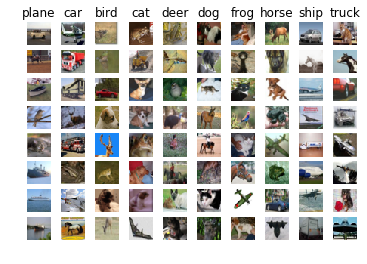

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
*Some of them yes, some of them not at all! misclassifying car or a plane with wheels as a truck or vice versa is not unintuitive. Classifying images with green background as a deer is like so. But, some of them are completeley unintuitive, like misclassifying car as a frog!*

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [25]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dims = [256, 512]
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_net = None
results = {}
learning_rates = [0.25, 0.5, 1]
batch_size = 256
num_classes = 10
regs = [0]
best_acc = -1

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for reg in regs:
            print("learning rate: {}, hidden size: {}, reg: {}".format(learning_rate, hidden_dim, reg))
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1500, batch_size=batch_size,
                learning_rate=learning_rate, learning_rate_decay=0.95,
                reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            train_acc = (net.predict(X_train_feats) == y_train).mean()
            results[(learning_rate, hidden_dim, reg)] = (train_acc, val_acc)
            print('Validation accuracy: ', val_acc)

            if (val_acc > best_acc):
                best_net = net
                best_acc = val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

learning rate: 0.25, hidden size: 256, reg: 0
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.015782
iteration 200 / 1500: loss 1.437847
iteration 300 / 1500: loss 1.308185
iteration 400 / 1500: loss 1.284407
iteration 500 / 1500: loss 1.413349
iteration 600 / 1500: loss 1.275955
iteration 700 / 1500: loss 1.270454
iteration 800 / 1500: loss 1.166368
iteration 900 / 1500: loss 1.251590
iteration 1000 / 1500: loss 1.222081
iteration 1100 / 1500: loss 1.156565
iteration 1200 / 1500: loss 1.201672
iteration 1300 / 1500: loss 1.095458
iteration 1400 / 1500: loss 1.131760
Validation accuracy:  0.577
learning rate: 0.25, hidden size: 512, reg: 0
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.975186
iteration 200 / 1500: loss 1.537700
iteration 300 / 1500: loss 1.342638
iteration 400 / 1500: loss 1.261869
iteration 500 / 1500: loss 1.307241
iteration 600 / 1500: loss 1.317598
iteration 700 / 1500: loss 1.173397
iteration 800 / 1500: loss 1.228734
iteration 900 /

In [26]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.573
